In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

#fonction pour transformer str en liste
import ast

In [2]:
chemin_bd = r"./bd_ignore/"


In [3]:
df_tmdb = pd.read_csv(chemin_bd + 'tmdb_full.csv')  # Dataset des films
df_names = pd.read_csv(chemin_bd + 'name.basics.tsv', sep='\t')  # Dataset des acteurs

/var/folders/2t/0mfg6g090d10lzzy264b5w300000gn/T/ipykernel_3977/237918243.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmdb = pd.read_csv(chemin_bd + 'tmdb_full.csv')  # Dataset des films


In [4]:
# Nettoyage des colonnes inutiles dans df_names
df_names = df_names[['primaryName', 'knownForTitles']]  # Conserver uniquement les colonnes nécessaires

# Exploser les titres associés (knownForTitles)
df_names = df_names.assign(knownForTitles=df_names['knownForTitles'].str.split(','))
df_names = df_names.explode('knownForTitles')  # Une ligne par titre associé

# Nettoyer et convertir la colonne 'release_date' en datetime dans df_tmdb
df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors='coerce')
df_tmdb['year'] = df_tmdb['release_date'].dt.year

# Supprimer les lignes sans 'year' ou 'genres'
df_tmdb = df_tmdb.dropna(subset=['year', 'genres'])

# Filtrer les films des années 2000
df_tmdb = df_tmdb[(df_tmdb['year'] >= 2000) & (df_tmdb['year'] <= 2024)]

# filtrer les genres
df_tmdb = df_tmdb[df_tmdb['genres'].str.contains("|".join(['Action', 'Drama', 'Comedy', 'Horror', 'Family', 'Adventure', 'Animation', 'Thriller']))]

# Exploser les genres associés (genres)
df_tmdb = df_tmdb.assign(genres=df_tmdb['genres'].str.split(','))
df_tmdb = df_tmdb.explode('genres')  # Une ligne par genre associé

# Merge avec le dataset des acteurs sur 'imdb_id'
df_tmdb['imdb_id'] = df_tmdb['imdb_id'].str.strip()  # Nettoyer d'éventuels espaces

# Enlever les []
df_tmdb['genres']=df_tmdb['genres'].apply(lambda x : str(x).replace('[','').replace(']',''))
df_tmdb['genres']=df_tmdb['genres'].apply(lambda x : str(x).replace("'",'').replace("'",''))

df_tmdb2 = df_tmdb.copy()
df_merged = pd.merge(df_tmdb, df_names, left_on='imdb_id', right_on='knownForTitles', how='left')

# Ajouter les noms des acteurs groupés par film
df_merged['actors'] = df_merged.groupby('imdb_id')['primaryName'].transform(lambda x: ', '.join(x.dropna()))
df_merged = df_merged.drop_duplicates(subset=['imdb_id'])  # Supprimer les doublons

# Sélection des colonnes pertinentes pour le modèle
features = ['popularity', 'vote_average', 'vote_count', 'budget', 'revenue', 'runtime']
df_filtered2 = df_merged[features + ['genres', 'actors', 'title', 'imdb_id']].fillna(0)


In [7]:
# on les met dans un fichier plus court pour la recherche
df_filtered2.to_csv(chemin_bd + 'resultat/df_filtered2.csv', index=False)
df_filtered_actor = pd.read_csv(chemin_bd + 'resultat/df_filtered2.csv')


In [8]:
df_filtered_actor.head()

,popularity,vote_average,vote_count,budget,revenue,runtime,genres,actors,title,imdb_id
0,1.930,7.738,21,0,0,15,Drama,Marc Meyer,Sunday in August,tt0425473
1,68.898,7.823,17625,94000000,940335536,100,Animation,"Ellen DeGeneres, Thomas Vicari, Andrew Stanton...",Finding Nemo,tt0266543
2,13.781,7.881,1555,12800000,40031879,141,Drama,"Catherine Deneuve, Joel Grey, Peter Stormare, ...",Dancer in the Dark,tt0168629
3,7.178,5.815,232,0,6593579,87,Horror,"Steve Allaway, Johnny Bamford, Oliver Barron, ...",The Dark,tt0411267
4,11.068,5.880,403,2500000,12300000,106,Drama,"Debbie Harry, Sarah Polley, Irene Blecua, Jim ...",My Life Without Me,tt0314412


In [9]:
# on selection une colonne interemediare avec deux acteurs
df_filtered2['first_two_actors'] = df_filtered2['actors'].apply(
    lambda x: ','.join(x.split(',')[:3]) if isinstance(x, str) else None
)

# on met en liste dans une nouvelle colonne 
df_filtered2['two_actors'] = df_filtered2['first_two_actors'].apply(lambda x: x.split(","))
df_filtered2['two_actors'] = df_filtered2['two_actors'].apply(lambda x: set(x))

# on supprime les colonnes inutiles
df_filtered2 = df_filtered2.drop(columns =['actors', 'first_two_actors'])
df_filtered2.head()

,popularity,vote_average,vote_count,budget,revenue,runtime,genres,title,imdb_id,two_actors
0,1.930,7.738,21,0,0,15,Drama,Sunday in August,tt0425473,{Marc Meyer}
1,68.898,7.823,17625,94000000,940335536,100,Animation,Finding Nemo,tt0266543,"{ Thomas Vicari, Ellen DeGeneres, Andrew Stan..."
437,13.781,7.881,1555,12800000,40031879,141,Drama,Dancer in the Dark,tt0168629,"{Catherine Deneuve, Peter Stormare, Joel Grey}"
789,7.178,5.815,232,0,6593579,87,Horror,The Dark,tt0411267,"{ Johnny Bamford, Oliver Barron, Steve Allaway}"
1170,11.068,5.880,403,2500000,12300000,106,Drama,My Life Without Me,tt0314412,"{ Irene Blecua, Sarah Polley, Debbie Harry}"


In [10]:
df_tmdb2.to_csv(chemin_bd + 'resultat/df_tmdb2.csv', index=False)
df_tmdb = pd.read_csv(chemin_bd + 'resultat/df_tmdb2.csv')

/var/folders/2t/0mfg6g090d10lzzy264b5w300000gn/T/ipykernel_3977/3921803254.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmdb = pd.read_csv(chemin_bd + 'resultat/df_tmdb2.csv')


In [11]:
df_filtered2.to_csv(chemin_bd + 'resultat/df_filtered.csv', index = False)
df_filtered = pd.read_csv(chemin_bd + 'resultat/df_filtered.csv')  # Dataset des films

In [12]:
df_filtered.sample(3)

,popularity,vote_average,vote_count,budget,revenue,runtime,genres,title,imdb_id,two_actors
59987,2.954,5.382,17,0,0,85,Drama,JL Family Ranch,tt5321174,"{'Lee Purcell', ' Samantha Doane', ' Chris Cof..."
79529,2.844,3.800,16,0,0,89,Crime,Three Blind Mice,tt0324952,"{'Richard Diesel', ' Jérôme George', ' Iseult ..."
29668,1.179,2.000,1,0,0,127,Drama,Adavi,tt11355282,{''}


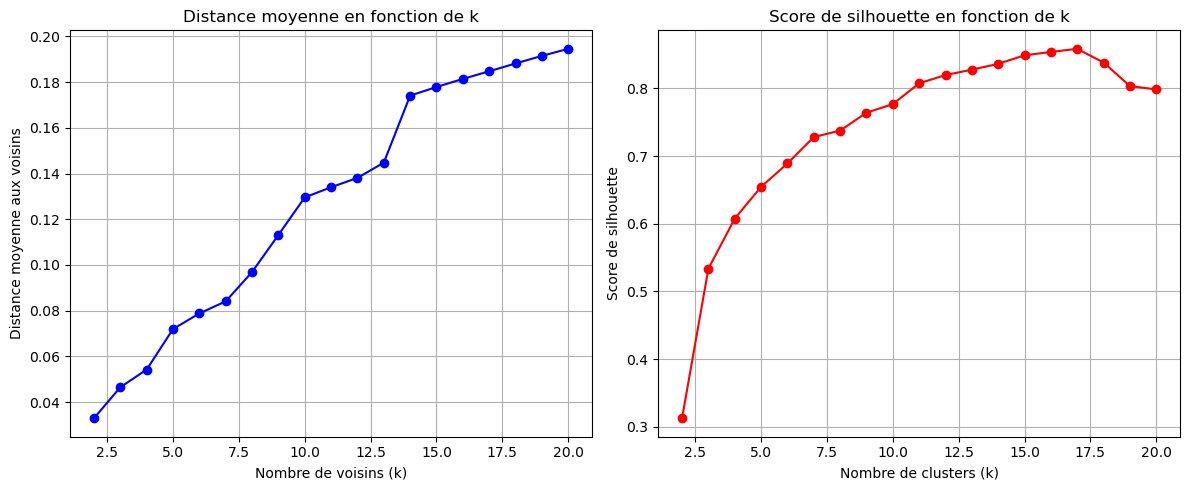

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def evaluate_k_with_silhouette(X_encoded, k_range):
    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Modèle Nearest Neighbors
        model = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
        model.fit(X_encoded)

        # Moyenne des distances aux k plus proches voisins
        distances, _ = model.kneighbors(X_encoded)
        avg_distance = distances[:, -1].mean()
        avg_distances.append(avg_distance)

        # Clustering avec K-Means pour silhouette_score
        if k > 1:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(X_encoded)
            labels = kmeans.labels_
            silhouette = silhouette_score(X_encoded, labels)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

# Définition de la plage de k à tester
k_range = range(2, 21)  # K-Means nécessite au moins k=2

# Évaluation des différentes valeurs de k
X_sample = X[:1000]  # Limiter à un sous-échantillon pour accélérer
avg_distances = evaluate_k(X_sample, k_range)

# Évaluation des distances moyennes et du score de silhouette
avg_distances, silhouette_scores = evaluate_k_with_silhouette(X_sample, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()


In [101]:
df_tmdb['poster_path'].sample(10)

44777     /fIpLF3k6G6LHrYIhDnU7dOeCm6r.jpg
194581    /uLHAzPOn5VJ4xFOYCkZ8Ywt5Xqp.jpg
15749     /jIvkeUF0dUiIrGVRZ87vfdrSXAN.jpg
188927                                 NaN
220587    /k36U2J2RyMplfnJu5D258wD7J45.jpg
141307    /sZ6sJ2zaZxmN2xYhKA2fzFEROYw.jpg
135109    /3J9yCSzYp2sS6nCiODirboiZHc6.jpg
166364    /2MaWPFMVGkCijyaNHDFzyxBJ6k1.jpg
93594     /8jLiOcInzCMUbv3cnt0pLZu31US.jpg
189702    /mElzapcKpvTc2BIKHcCDkkx8a4U.jpg
Name: poster_path, dtype: object

In [ ]:
# essai film base

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import streamlit as st
import pandas as pd
import re

In [14]:
# Fonction pour rechercher des titres
def search_movies(film_nom, df):
    results = df[df['title'].str.contains(film_nom, case=False, na=False)]
    return results

# Interface utilisateur avec Streamlit
st.title("Recherche et sélection de films")
film_nom = st.text_input("Entrez le titre ou une partie du titre du film :")

if film_nom:  # Vérifier si l'utilisateur a saisi un texte
    results = search_movies(film_nom, df_filtered)
    
    if not results.empty:
        st.write("Voici les films trouvés correspondant à votre recherche :")
        # Affichage des résultats sous forme de tableau interactif
        st.dataframe(results[['genres' 'title']])
        
        # Permettre à l'utilisateur de choisir un film
        selected_id = st.selectbox(
            "Sélectionnez l'ID du film correspondant :",
            options=results['id'].tolist()
        )
        
        # Afficher les détails du film sélectionné
        if selected_id:
            selected_movie = df_filtered[df_filtered['id'] == selected_id]
            st.write("Vous avez sélectionné :")
            st.write(selected_movie)
    else:
        st.write("Aucun film trouvé pour votre recherche.")

In [15]:
search_movies('nemo', df_filtered)

,popularity,vote_average,vote_count,budget,revenue,runtime,genres,title,two_actors
1,68.898,7.823,17625,94000000,940335536,100,Animation,Finding Nemo,"['Ellen DeGeneres', ' Thomas Vicari']"
12394,0.802,6.000,2,0,0,15,Animation,Laika & Nemo,"['Felicitas Müller', ' Cornelius Koch']"
19482,0.600,3.100,5,0,0,0,Horror,Insidiae Nemoris,"['Francesco Biscione', ' Elisa Betti']"
31075,1.400,7.000,2,0,0,78,Drama,Mnemophrenia,"['Gary Cargill', ' Cally Lawrence']"
31257,1.400,0.000,0,0,0,0,Drama,Cesta do nemožna,"['Veronika Matousková', ' Adrian Tristan Peter']"
42766,3.054,5.700,3,0,0,95,Animation,Anemone: Eureka Seven Hi-Evolution,"['Nobuaki Nagano', ' Yûji Takahashi']"
99259,0.600,0.000,0,0,0,0,Drama,Il mnemonista,"['Sandro Lombardi', ' Valeria Morosini']"
100077,0.840,2.800,2,0,0,107,Drama,Mullassery Madhavan Kutty Nemom P. O.,"['Kumar Nanda', ' Sonal Devaraj']"


In [ ]:
#### jonathan

In [ ]:
# liste des acteurs uniques

list_actor = df_filtered['two_actors'].apply(lambda x: [actor.strip() for actor in ast.literal_eval(x)] if pd.notna(x) else [])
# on convertit str en list
 
actor_unique = set()
for actor in list_actor :
    actor_unique.update(actor)
# on parcourt ttes les list d'acteurs et on les mets dans actor_unique

list_actor_unique = list(actor_unique)

list_actor_unique

In [ ]:
# filtre avec le nom d'un acteur

actor_search  = 'Thomas Vicari'
df_filtered[df_filtered['two_actors'].apply(lambda x: actor_search in [a.strip() for a in ast.literal_eval(x)] if pd.notna(x) else False )]

In [ ]:
        #### jonathan affichage des images

        # for idx, res in resultats.iterrows():
        #     title = res.get('title', 'Titre inconnu')
        #     #poster_path = res['poster_path']
        #     #imdb_id = res['imdb_id']
        #     poster_path = res.get('poster_path')
        #     imdb_id = res.get('imdb_id')

        #     col_courante = cols[idx % 3]
        #     # Ajouter les informations dans les colonnes
        #     with col_courante :
        #         if pd.notna(poster_path) :
        #             # Afficher l'affiche du film
        #             #st.image(f"https://image.tmdb.org/t/p/w500{poster_path}", width=150, caption=title)
        #             st.write(f"![poster](https://image.tmdb.org/t/p/w500{poster_path}")
        #         else:
        #             st.write(f"**{title}** (Aucune affiche disponible)")

        #         # Lien vers IMDb
        #         if imdb_id and str(imdb_id).strip():
        #             st.write(f"[Voir sur IMDb](https://www.imdb.com/title/{imdb_id}/)")

    # st.write(f"### Films sélectionnés :")
    # st.write(resultats)